In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from tqdm import tqdm

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
generator = tf.keras.Sequential()

generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())
generator.add(layers.Reshape((7, 7, 256)))

generator.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

In [ ]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_8 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 7, 7, 256)        1638400   
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 256)       

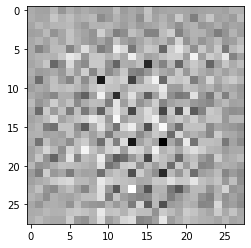

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
discriminator = tf.keras.Sequential()

discriminator.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(32))
discriminator.add(layers.Dense(2))

In [ ]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)        

In [ ]:
decision = discriminator(generated_image)
print(np.argmax(decision))

0


In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm(dataset):
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

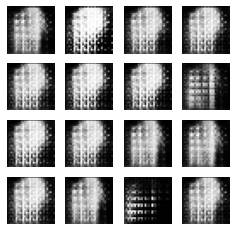

Time for epoch 6 is 56.70091700553894 sec


100%|██████████| 235/235 [00:55<00:00,  4.29it/s]

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

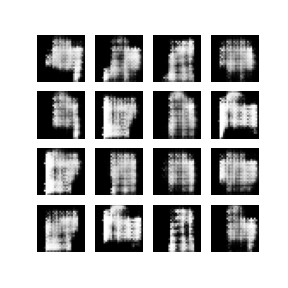

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-hjhf1xm6
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-hjhf1xm6
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179720 sha256=d53db8ecf3d497dd8f738ccc326313780de0512e3647845cf06a603c62e9ee49
  Stored in directory: /tmp/pip-ephem-wheel-cache-upfvbadt/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs



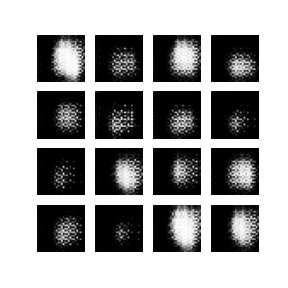

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)